In [1]:
import pathlib
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


%matplotlib inline
import holidays
import pathlib
import datetime
from os import PathLike
from typing import Union

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

import palettable
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline

#from scipy.stats import linregress
#import pymc3 as pm


#plt.style.use('grayscale')
# Custom Overrides to grayscale
params = {'legend.fontsize': 'x-large',
          'lines.linewidth': 0.75,
      'figure.figsize': (15, 7),
          'grid.color': 'white',
          'axes.axisbelow': False,
          'axes.grid': True,
          'axes.grid.axis': 'y',
     'axes.labelsize': 'x-large',
     'axes.titlesize':'xx-large',
     'xtick.labelsize':'x-large',
     'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
figsize=(15,7)


In [2]:
#import libraries
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
sns.set_context("poster")

import holidays
from sklearn import feature_selection as fs
from sklearn import model_selection as ms

In [3]:
df = pd.read_csv('One_hr_data.csv')
df.head()

,timestamp,demand,temp,dew_point,humidity,wind_speed,pressure,condition
0,1/01/2017 0:00,3474.570,21.11,7.78,43,10,29,Fair
1,1/01/2017 1:00,3371.978,21.11,7.22,40,21,29,Fair / Windy
2,1/01/2017 2:00,3287.374,20.00,7.78,46,20,29,Fair
3,1/01/2017 3:00,3218.992,17.78,8.89,56,20,29,Fair
4,1/01/2017 4:00,3203.696,17.22,8.89,59,23,29,Fair / Windy


In [4]:
df.rename(columns={"timestamp" : 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M',infer_datetime_format=True).dt.strftime('%Y-%m-%d %H:%M')



## Checking Data structure

In [5]:
df.info

<bound method DataFrame.info of                    Date    demand   temp  dew_point  humidity  wind_speed  \
0      2017-01-01 00:00  3474.570  21.11       7.78        43          10   
1      2017-01-01 01:00  3371.978  21.11       7.22        40          21   
2      2017-01-01 02:00  3287.374  20.00       7.78        46          20   
3      2017-01-01 03:00  3218.992  17.78       8.89        56          20   
4      2017-01-01 04:00  3203.696  17.22       8.89        59          23   
...                 ...       ...    ...        ...       ...         ...   
45427  2022-03-08 19:00  6038.368  23.90      15.00        57          13   
45428  2022-03-08 20:00  5602.400  23.90      15.00        57          13   
45429  2022-03-08 21:00  5109.266  23.90      15.00        57          13   
45430  2022-03-08 22:00  4613.252  23.90      15.00        57          13   
45431  2022-03-08 23:00  4249.630  23.90      15.00        57          13   

       pressure     condition  
0          

In [6]:
df.dtypes

Date           object
demand        float64
temp          float64
dew_point     float64
humidity        int64
wind_speed      int64
pressure        int64
condition      object
dtype: object

In [7]:
df.shape

(45432, 8)

In [8]:
df.isnull().sum()

Date          0
demand        0
temp          0
dew_point     0
humidity      0
wind_speed    0
pressure      0
condition     0
dtype: int64

# Visual Inspection

<AxesSubplot:>

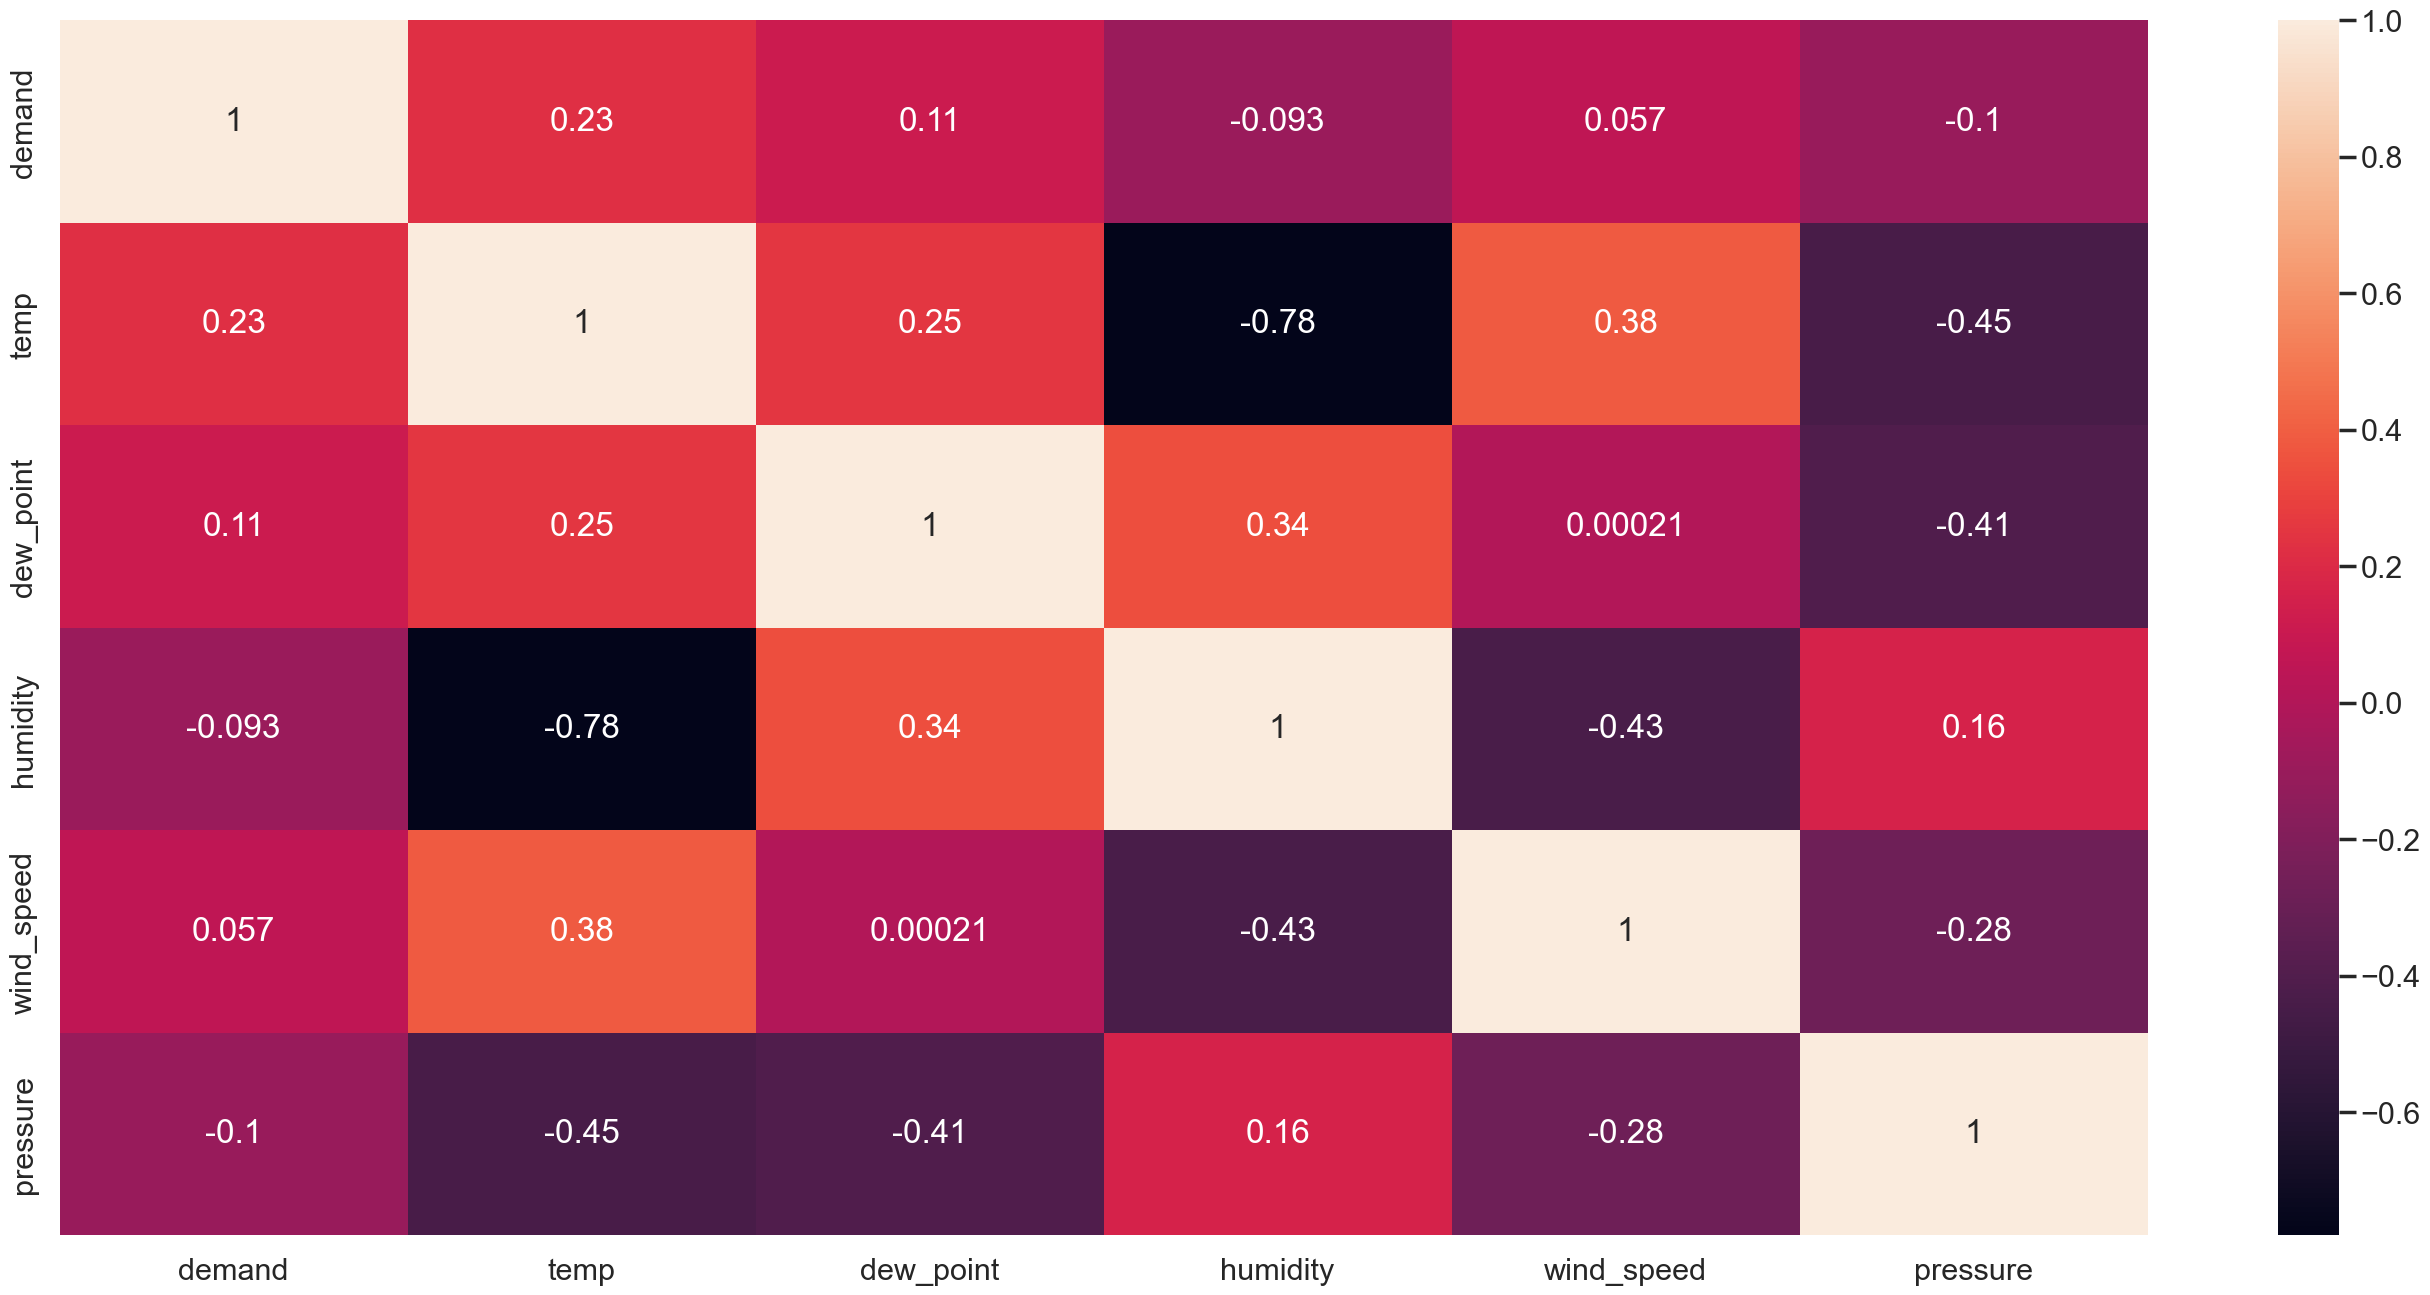

In [9]:
plt.figure(figsize=(30,15))
sns.heatmap(df.corr(), annot=True)

# Demand Overview

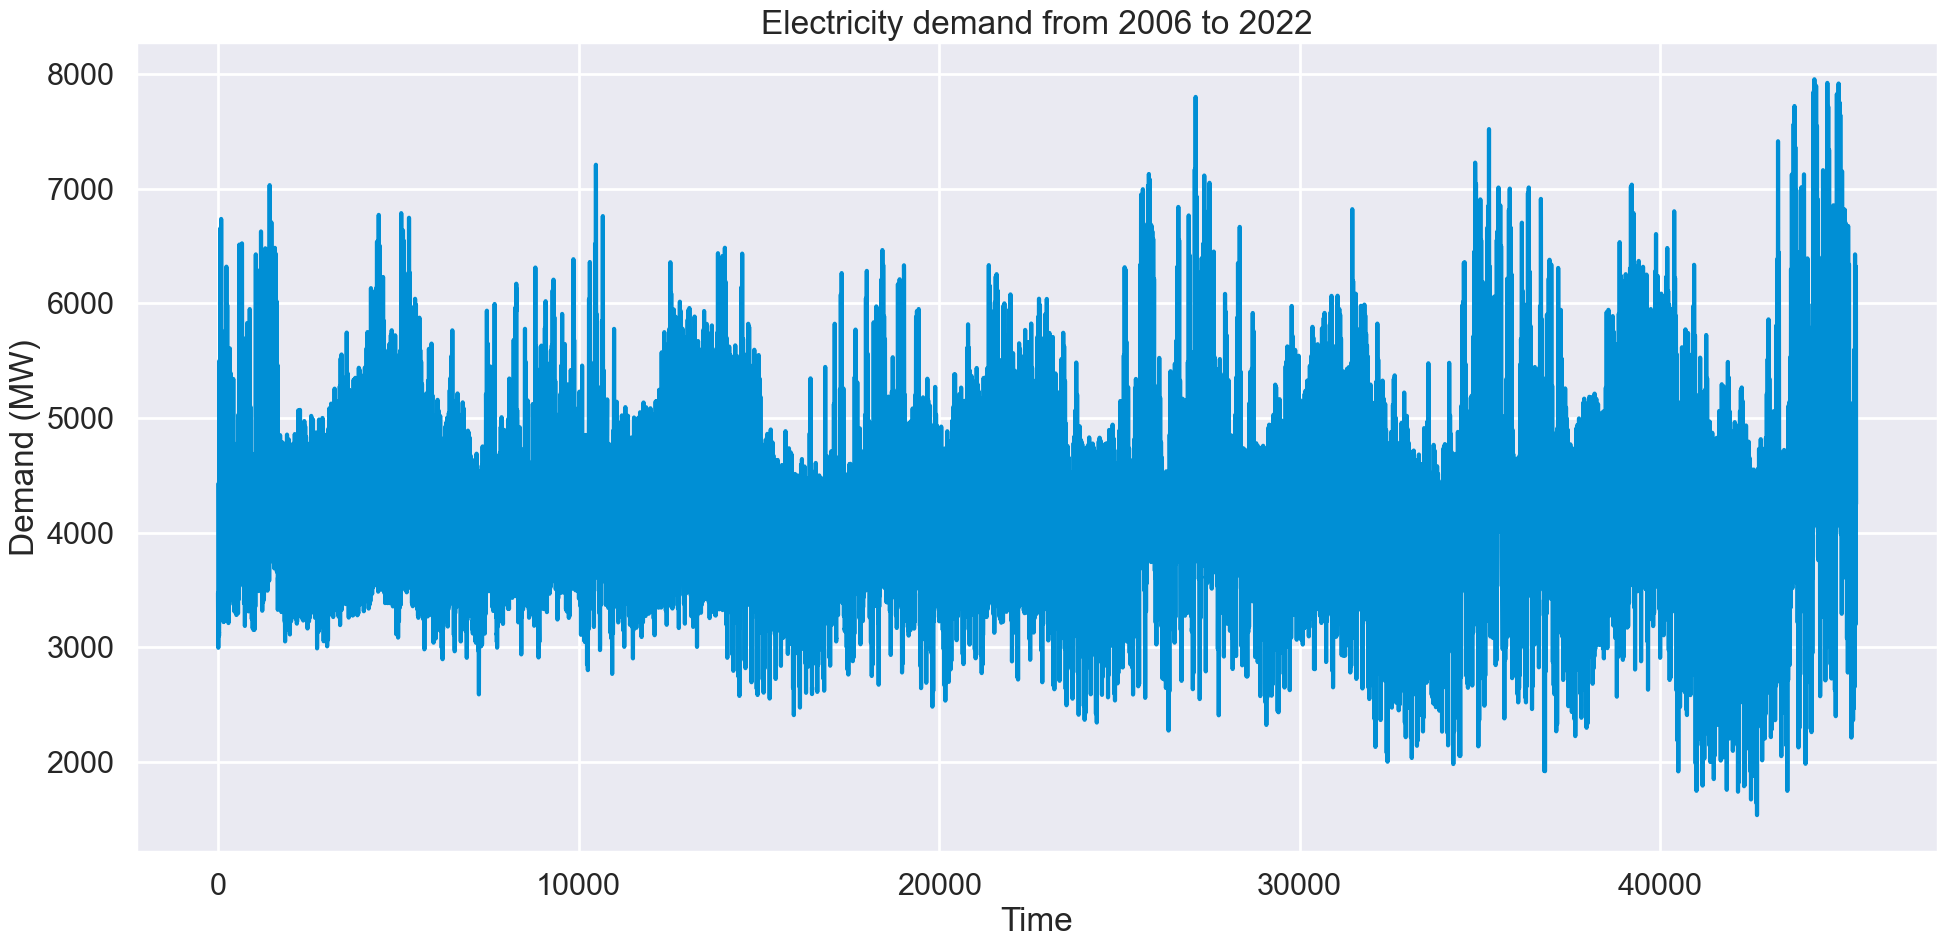

In [10]:
# Plot the time series
ax = df.plot(y="demand", figsize=[20, 10], legend=False)
ax.set_ylabel("Demand (MW)")
ax.set_xlabel("Time")
ax.set_title("Electricity demand from 2006 to 2022")
plt.tight_layout()

# Verify Data integrity, and Identify Problems

{'whiskers': [<matplotlib.lines.Line2D at 0x2468ff192e0>,
 'caps': [<matplotlib.lines.Line2D at 0x2468ff19a00>,
 'boxes': [<matplotlib.lines.Line2D at 0x2468ff06f10>],
 'medians': [<matplotlib.lines.Line2D at 0x2468ff27160>],
 'fliers': [<matplotlib.lines.Line2D at 0x2468ff274f0>],
 'means': []}

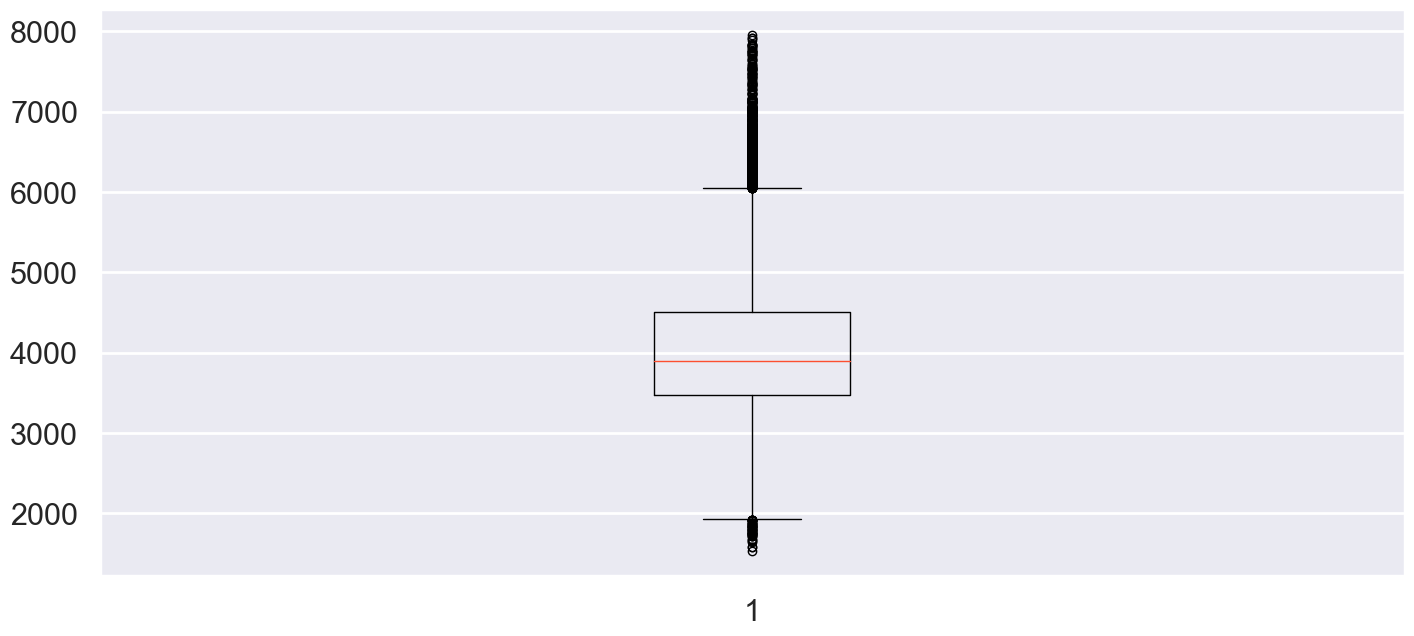

In [11]:
plt.boxplot(df.loc[:,"demand"])

In [12]:
#creating a separate data for weekly and monthly analysis
df1 = df.copy()
df1['Date'] = pd.to_datetime(df1['Date'], format="%Y-%m-%d %H")
df1 = df1.interpolate(method='bfill')
df1 = df1.interpolate(method='ffill')

In [13]:
df1['hour'] = df1['Date'].dt.hour
df1['day'] = df1['Date'].dt.dayofyear
df1['week'] = df1['Date'].dt.week
df1['month'] = df1['Date'].dt.month
df1['weekday'] = df1['Date'].dt.day_name()
df1["day_of_month"] = df1['Date'].dt.day

#dictionary for useful variables

AU_holidays = holidays.AUS()
df1['holiday'] = [1 if d in AU_holidays else 0 for d in df1['Date']]
df1[df1['holiday'] == 1]

df1['isWorkDay'] = df1.apply(lambda x: 'no' if ((x['holiday'] == 1) or
                                          (x['weekday'] in ['Sunday', 'Saturday'])) else 'yes', axis=1)

cat_cols = ['hour','day','week','month','weekday','holiday','isWorkDay','condition']
for col in cat_cols:
  df1[col] = df1[col].astype('category')

In [28]:
df1

,Date,demand,temp,dew_point,humidity,wind_speed,pressure,condition,hour,day,week,month,weekday,day_of_month,holiday,isWorkDay
0,2017-01-01 00:00:00,3474.570,21.11,7.78,43,10,29,Fair,0,1,52,1,Sunday,1,1,no
1,2017-01-01 01:00:00,3371.978,21.11,7.22,40,21,29,Fair / Windy,1,1,52,1,Sunday,1,1,no
2,2017-01-01 02:00:00,3287.374,20.00,7.78,46,20,29,Fair,2,1,52,1,Sunday,1,1,no
3,2017-01-01 03:00:00,3218.992,17.78,8.89,56,20,29,Fair,3,1,52,1,Sunday,1,1,no
4,2017-01-01 04:00:00,3203.696,17.22,8.89,59,23,29,Fair / Windy,4,1,52,1,Sunday,1,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45427,2022-03-08 19:00:00,6038.368,23.90,15.00,57,13,29,Fair,19,67,10,3,Tuesday,8,0,yes
45428,2022-03-08 20:00:00,5602.400,23.90,15.00,57,13,29,Fair,20,67,10,3,Tuesday,8,0,yes
45429,2022-03-08 21:00:00,5109.266,23.90,15.00,57,13,29,Fair,21,67,10,3,Tuesday,8,0,yes
45430,2022-03-08 22:00:00,4613.252,23.90,15.00,57,13,29,Fair,22,67,10,3,Tuesday,8,0,yes


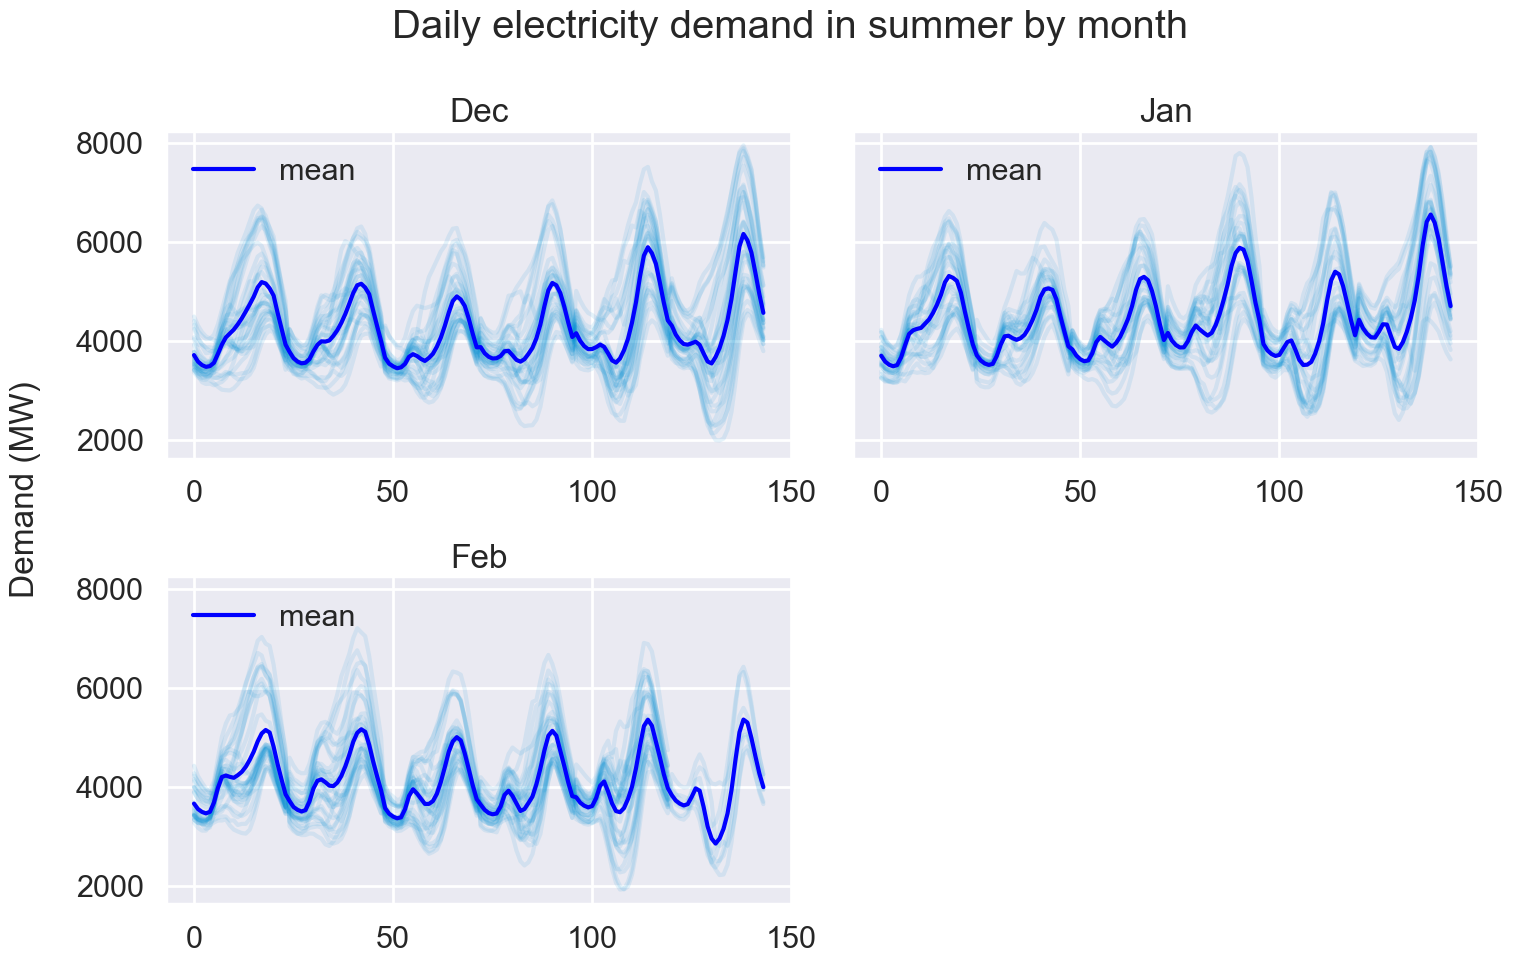

In [16]:
# Plot the electricity demand for each day
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[15, 10], sharey=True)
ax = ax.flatten()
sns_blue = sns.color_palette(as_cmap=True)[0]
MONTHS = ["Dec","Jan", "Feb"]
for ix, month in enumerate(MONTHS):

    # Plot individual ts
    daily_ts = []
    for _, ts in (
        df1[["demand", "day_of_month", "month"]]
        .query(f"month == {ix+1}")
        .groupby("day_of_month")
    ):
        daily_ts.append(ts.reset_index()["demand"])
        ts.reset_index()["demand"].plot(
            alpha=0.1, ax=ax[ix], color=sns_blue, label="_no_legend_"
        )
        #ax[ix].set_xticks(np.arange(0, len(ts) + 1, 8))
        ax[ix].set_title(month)

    # Plot the mean ts
    pd.concat(daily_ts, axis=1).mean(axis=1).plot(
        ax=ax[ix], color="blue", label="mean", legend=True
    )
    ax[ix].legend(loc="upper left", frameon=False)

    

#fig.text(0.5, -0.02, "Hour of day", ha="center")
fig.text(-0.02, 0.5, "Demand (MW)", va="center", rotation="vertical")
fig.suptitle("Daily electricity demand in summer by month")
fig.delaxes(ax[-1])
fig.tight_layout()

(array([  157.,  1310.,  9510., 16057., 10365.,  5104.,  1975.,   693.,
          198.,    63.]),
 array([1536.858 , 2178.4774, 2820.0968, 3461.7162, 4103.3356, 4744.955 ,
        5386.5744, 6028.1938, 6669.8132, 7311.4326, 7953.052 ]),
 <BarContainer object of 10 artists>)

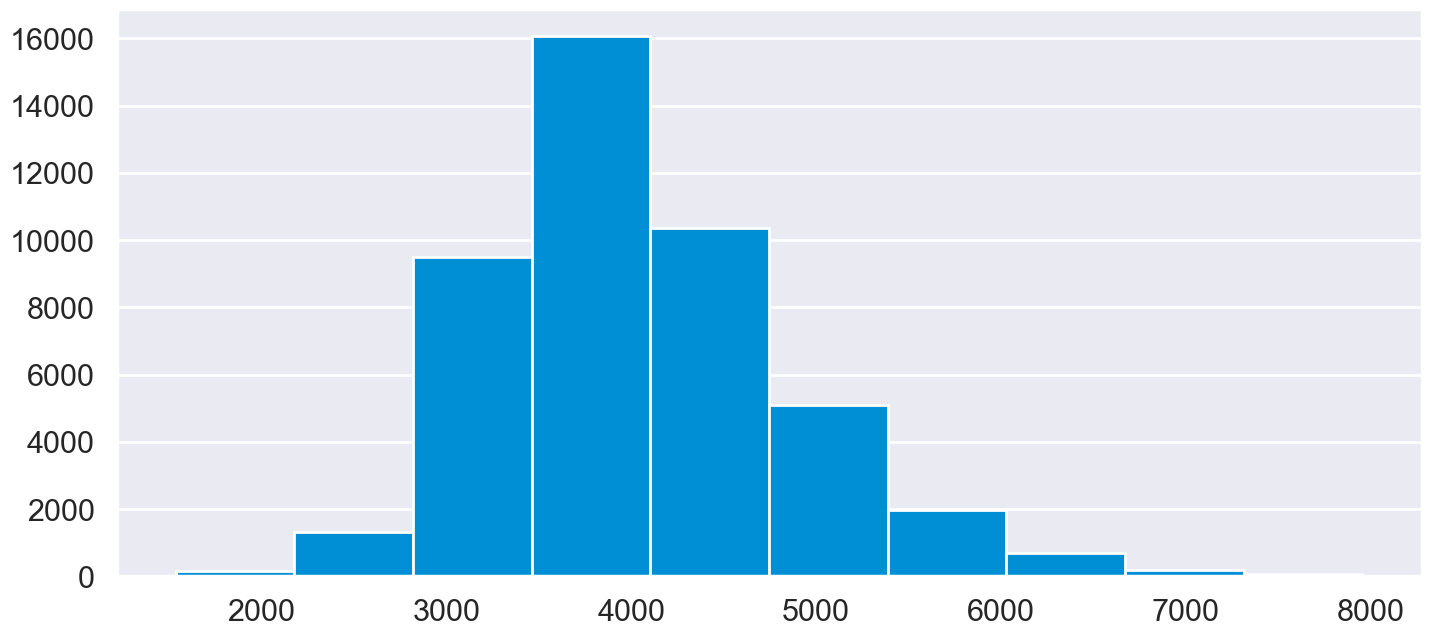

In [18]:
plt.hist(df1["demand"])

## Check Peak Data against Alternate Source

Lets check this with weather data set

# Weather Overview

# Relationship Between Temperature and Power Demand

In [41]:
max_demand = pd.read_csv('max_demand.csv', index_col=0, parse_dates=True)
#df_merged['timestamp']= pd.to_datetime(df_merged['timestamp'])
max_demand.head()

,Operational Demand (MW),Transpiration,Rain,Evaporation,Max Temp,Min Temp,Max Hum,Min Hum,Av Wind,Solar Rad,Year,month,Day_of_week,Day_of_month,Day_of_year,week_of_year,state_holiday,mnth_sin,mnth_cos
Date,,,,,,,,,,,,,,,,,,,
2009-01-01,2543.140,11.2,0,11.6,37.2,18.8,65,20,6.1,34.01,2009,1,3,1,1,1,True,0.0,1.0
2009-02-01,2893.868,10.2,0,12.8,36.1,21.9,70,25,5.31,34.25,2009,1,4,2,2,1,False,0.0,1.0
2009-03-01,2450.920,9.4,0,11.8,34.4,20.3,79,29,5.45,34.11,2009,1,5,3,3,1,False,0.0,1.0
2009-04-01,2526.302,10.5,0,11.2,36.5,18.5,62,20,5.25,34.05,2009,1,6,4,4,1,False,0.0,1.0
2009-05-01,3106.014,11.9,0,11.4,37.2,21.8,63,17,6.77,34.18,2009,1,0,5,5,2,False,0.0,1.0


In [42]:
max_demand['daytype'] = ['Weekday' if x<5 else 'Weekend' for x in max_demand['Day_of_week']]
max_demand

,Operational Demand (MW),Transpiration,Rain,Evaporation,Max Temp,Min Temp,Max Hum,Min Hum,Av Wind,Solar Rad,Year,month,Day_of_week,Day_of_month,Day_of_year,week_of_year,state_holiday,mnth_sin,mnth_cos,daytype
Date,,,,,,,,,,,,,,,,,,,,
2009-01-01,2543.140,11.2,0,11.6,37.2,18.8,65,20,6.1,34.01,2009,1,3,1,1,1,True,0.0,1.000000,Weekday
2009-02-01,2893.868,10.2,0,12.8,36.1,21.9,70,25,5.31,34.25,2009,1,4,2,2,1,False,0.0,1.000000,Weekday
2009-03-01,2450.920,9.4,0,11.8,34.4,20.3,79,29,5.45,34.11,2009,1,5,3,3,1,False,0.0,1.000000,Weekend
2009-04-01,2526.302,10.5,0,11.2,36.5,18.5,62,20,5.25,34.05,2009,1,6,4,4,1,False,0.0,1.000000,Weekend
2009-05-01,3106.014,11.9,0,11.4,37.2,21.8,63,17,6.77,34.18,2009,1,0,5,5,2,False,0.0,1.000000,Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-08,3061.642,2.2,0,1.4,19.6,2.8,96,43,1.9,15.3,2022,8,3,11,223,32,False,-0.5,-0.866025,Weekday
2022-12-08,2812.890,3.5,0,2,21.0,6,92,41,5.4,15.42,2022,8,4,12,224,32,False,-0.5,-0.866025,Weekday
2022-08-13,2921.720,2.9,0,4,16.8,10.9,94,34,5.97,5.67,2022,8,5,13,225,32,False,-0.5,-0.866025,Weekend


In [43]:
max_demand.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4970 entries, 2009-01-01 to 2022-08-15
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Operational Demand (MW)  4970 non-null   float64
 1   Transpiration            4970 non-null   object 
 2   Rain                     4970 non-null   object 
 3   Evaporation              4970 non-null   object 
 4   Max Temp                 4970 non-null   float64
 5   Min Temp                 4970 non-null   object 
 6   Max Hum                  4970 non-null   object 
 7   Min Hum                  4970 non-null   object 
 8   Av Wind                  4970 non-null   object 
 9   Solar Rad                4970 non-null   object 
 10  Year                     4970 non-null   int64  
 11  month                    4970 non-null   int64  
 12  Day_of_week              4970 non-null   int64  
 13  Day_of_month             4970 non-null   int64  
 14  Day_of

In [44]:
#max_demand['Max Temp']= max_demand['Max Temp'].astype(float)


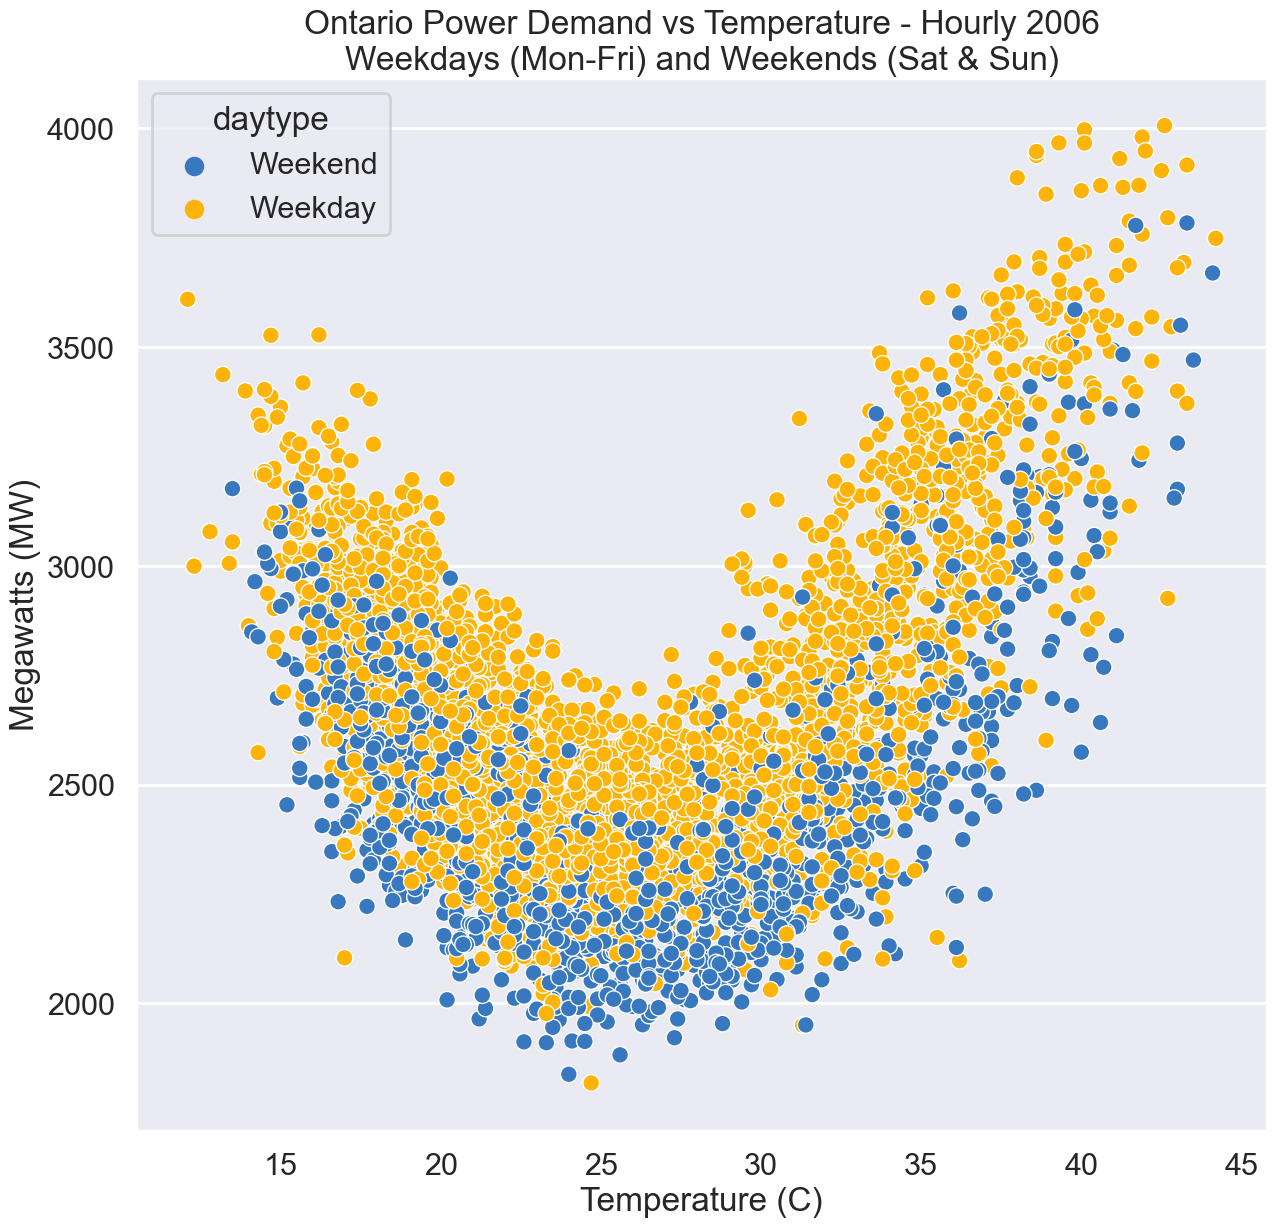

In [45]:
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))
fig, ax = plt.subplots(frameon=False, figsize=(13,13))
sns.scatterplot(x="Max Temp", y="Operational Demand (MW)",
                hue="daytype",
                hue_order=['Weekend', 'Weekday'],
                data=max_demand, ax=ax, legend='full')
#plt.title('')
ax.set_ylabel('Megawatts (MW)')
ax.set_xlabel('Temperature (C)')
ax.set_title('Ontario Power Demand vs Temperature - Hourly 2006\nWeekdays (Mon-Fri) and Weekends (Sat & Sun)')
#plt.savefig('saved-images/ontario-power-demand-vs-temperature-hourly-2006-scatterplot.PNG')
plt.show();

# Power Demand Distribution - Summer 

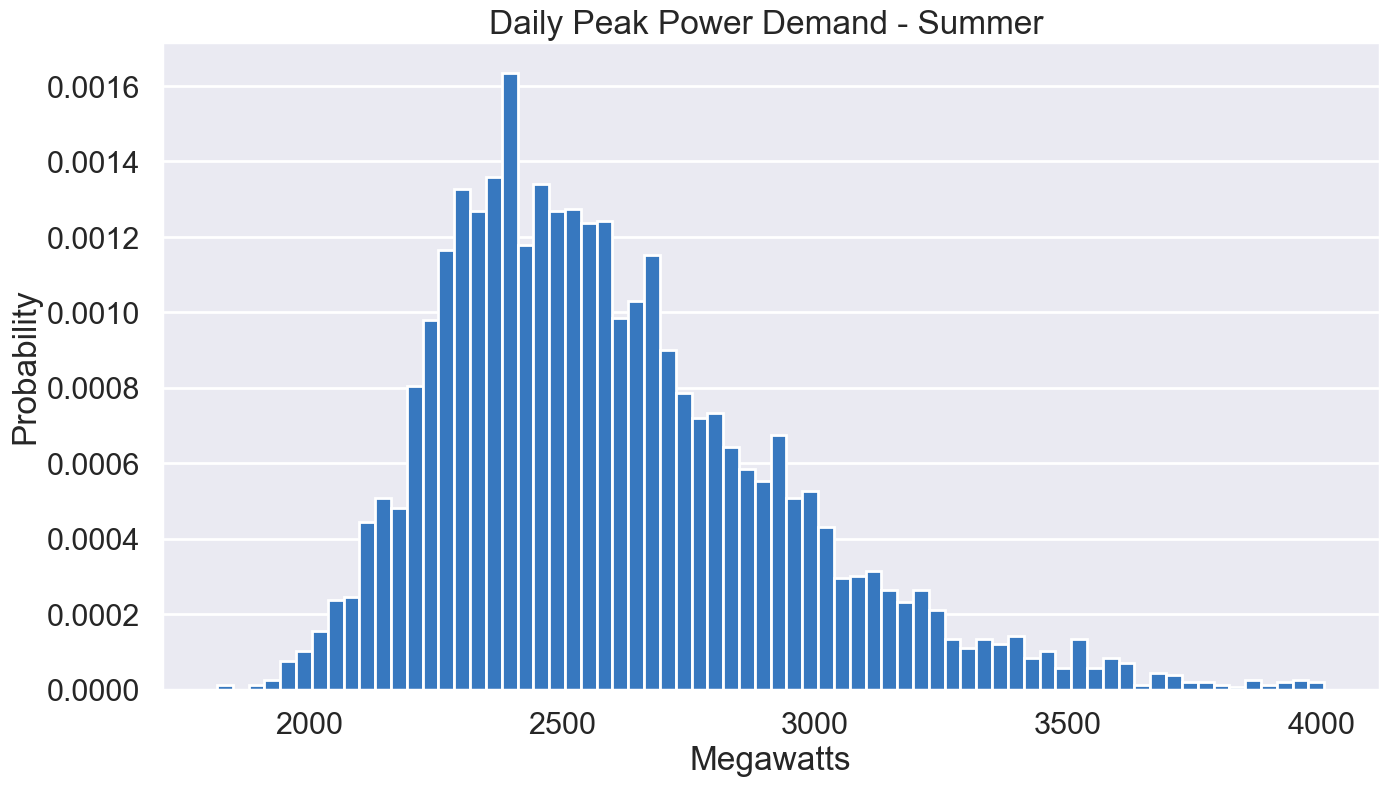

In [48]:
# Put histogram here and identify dual peak
bins=int(np.sqrt(len(y)))
fig, ax = plt.subplots(figsize=(14,8))
ax.hist(y, bins = bins, density=True)
ax.set_ylabel('Probability')
ax.set_xlabel('Megawatts')
ax.set_title('Daily Peak Power Demand - Summer ')
plt.show();

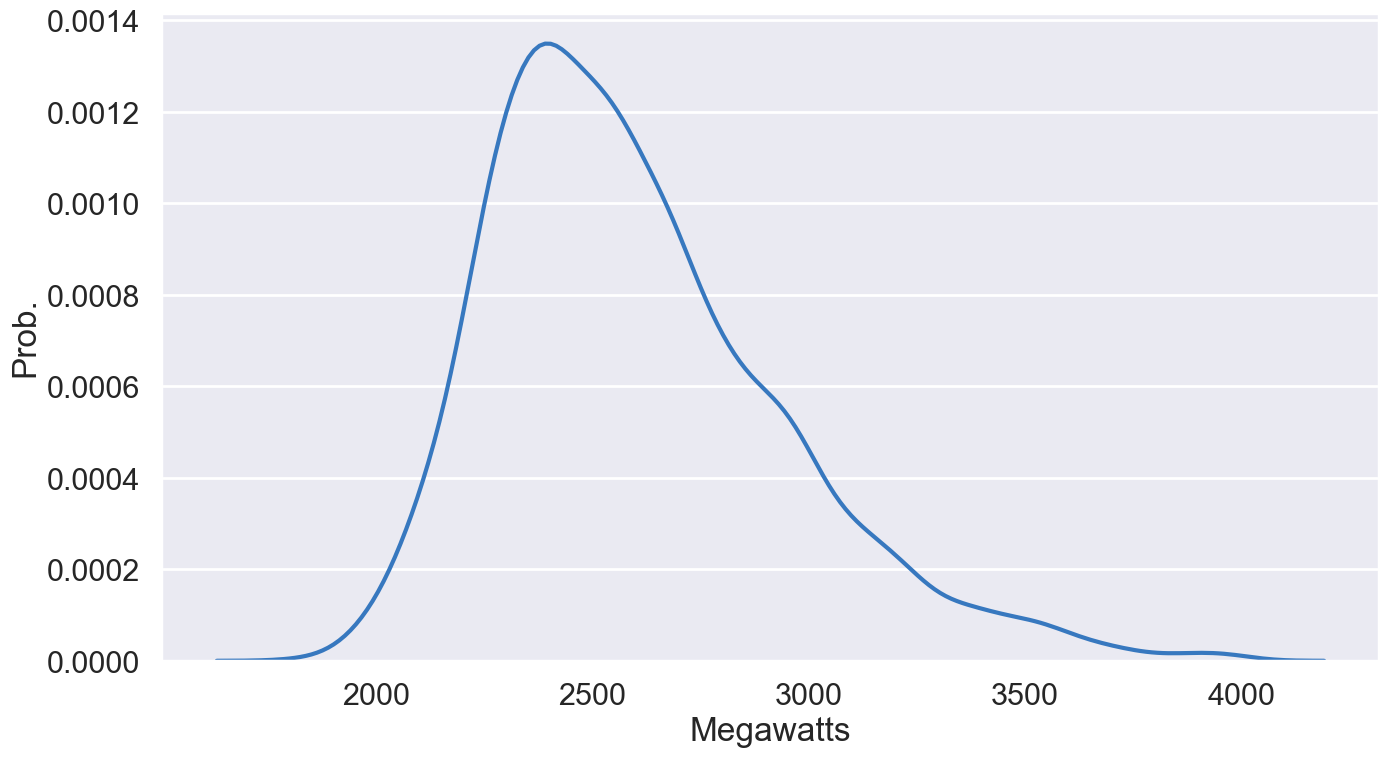

In [49]:
fig, ax = plt.subplots(figsize=(14,8))
ax.set_xlabel('Megawatts')
ax.set_ylabel('Prob.')
sns.kdeplot(y, ax=ax);

# Temperature - Summer 

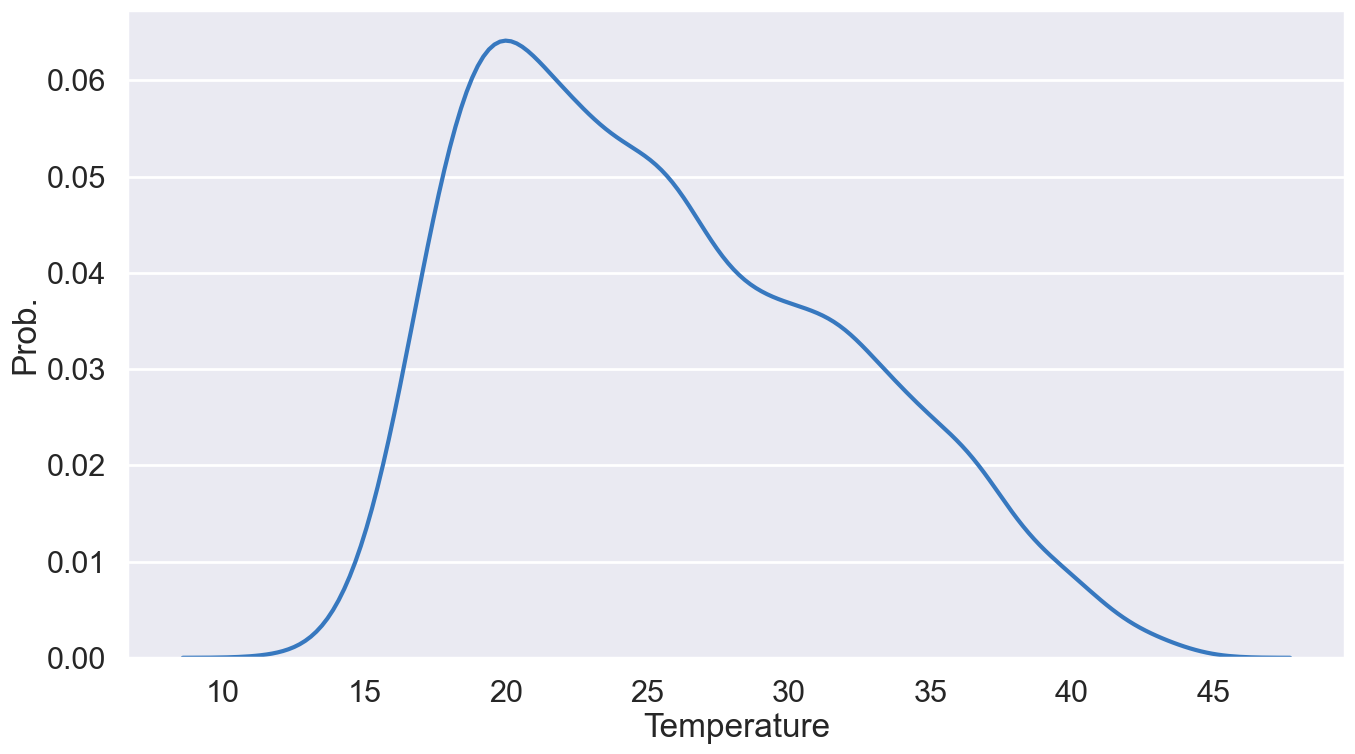

In [50]:
fig, ax = plt.subplots(figsize=(14,8))
ax.set_xlabel('Temperature')
ax.set_ylabel('Prob.')
sns.kdeplot(x, ax=ax);